<a href="https://colab.research.google.com/github/DevBatra05/DeepLearningLab/blob/main/Lab_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing CNN: Convolution, Pooling, Feature Maps Visualization


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


100%|██████████| 9.91M/9.91M [00:00<00:00, 116MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 32.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 93.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.07MB/s]


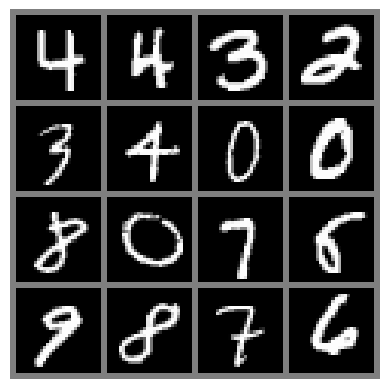

Labels: 4 4 3 2 3 4 0 0 8 0 7 6 9 8 7 6


In [2]:
# Normalize images (0 to 1 → mean=0.5, std=0.5 for -1 to 1 range)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Train and Test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Show a few sample images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap="gray")
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16], nrow=4))
print("Labels:", ' '.join(str(labels[j].item()) for j in range(16)))


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # 1 input channel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # after two poolings: 28→14→7
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
for epoch in range(1):  # 1 epoch for demo
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 200 == 199:  # print every 200 mini-batches
            print(f"[{epoch+1}, {i+1}] loss: {running_loss/200:.3f}")
            running_loss = 0.0

print("✅ Training Completed")


[1, 200] loss: 0.409
[1, 400] loss: 0.114
[1, 600] loss: 0.083
[1, 800] loss: 0.069
✅ Training Completed


In [6]:
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on 10k MNIST test images: {100 * correct / total:.2f}%")


Accuracy on 10k MNIST test images: 98.36%


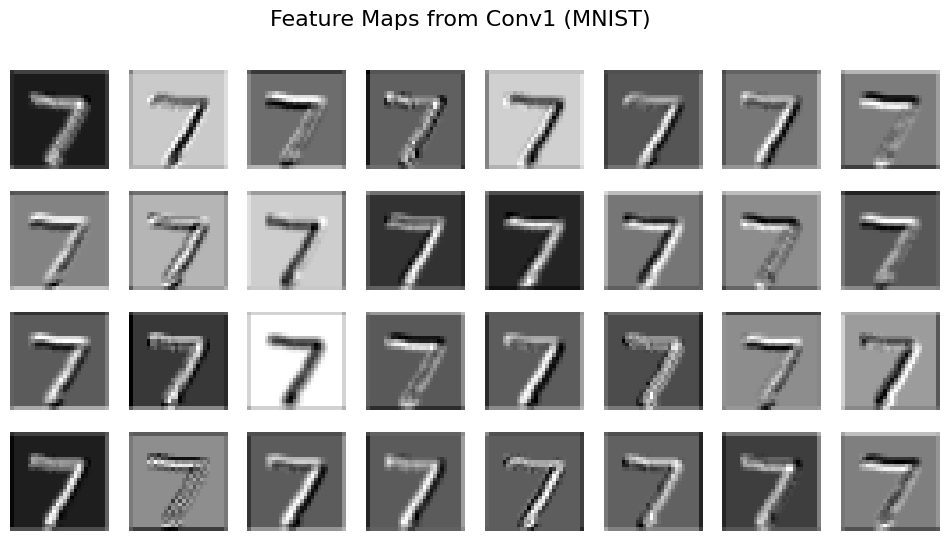

In [7]:
def visualize_feature_maps(model, images):
    with torch.no_grad():
        conv1_output = model.conv1(images)
        conv1_output = conv1_output[0]  # first image in batch

    fig, axes = plt.subplots(4, 8, figsize=(12,6))
    for i in range(32):
        ax = axes[i//8, i%8]
        ax.imshow(conv1_output[i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.suptitle("Feature Maps from Conv1 (MNIST)", fontsize=16)
    plt.show()

# Get one batch of images
dataiter = iter(testloader)
images, labels = next(dataiter)

visualize_feature_maps(model, images)
